In [1]:
import os
import sys
from copy import deepcopy

In [29]:
from matplotlib.ticker import PercentFormatter
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as SciOpt
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.precision', 2)

In [30]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.model.builder import LearnedCostModelBuilder, ClassicModel, FlexibleModel
from endure.lcm.data.generator import LevelGenerator
from endure.ltune.data.generator import LTuneGenerator
import endure.lsm.cost_model as CostFunc

In [31]:
config = Reader.read_config('../../endure.toml')

In [32]:
model_path = '/data/models/lcm/level-05-10-v0'
config_model = Reader.read_config(os.path.join(model_path, 'endure.toml'))

# Loss Graph

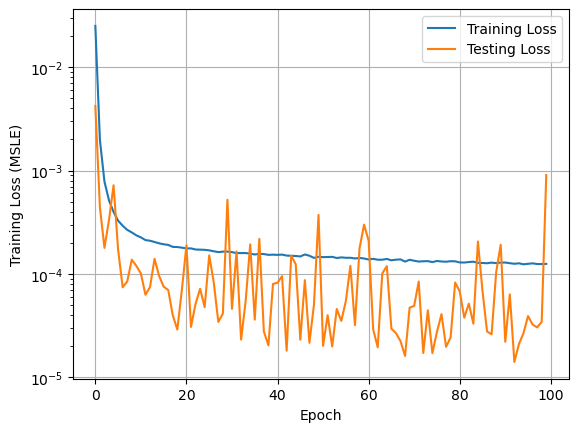

In [33]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config_model["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
_ = ax.legend()

# Building

## Model

In [142]:
# model_name = os.path.join(model_path, 'best.model')
model_name = os.path.join(model_path, 'checkpoints/epoch_20.checkpoint')

builder = LearnedCostModelBuilder(config_model)
model = builder.build_model()
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

## Generator

In [143]:
gen = LevelGenerator(config_model)

In [144]:
gen.generate_row_csv()

[0.017586799955744525,
 0.011605170767894963,
 0.15866002760234252,
 0.4845156825354958,
 0.10498319316978744,
 0.011498506483061596,
 0.03073627171474426,
 0.8527820286324067,
 64.0,
 3.5994162432610826e-07,
 2048,
 9.004536498793712,
 537514569,
 4.213,
 17]

# Utils

In [145]:
def to_array(workload: dict):
    return np.array([workload[x] for x in ('z0', 'z1', 'q', 'w')])

In [146]:
def l2_norm(a, b):
    return np.linalg.norm((a, b), 2)

In [209]:
def eval_lcm(design, system, wl):
    h, T = design
    B, s, E, H, N = system
    z0, z1, q, w = wl
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    T = T - config['lsm']['size_ratio']['min']
    T = np.eye(categories, dtype=np.int32)[T]
    feats = np.array([z0, z1, q, w, B, s, E, H, N, h])
    inputs = np.concatenate((feats, T))
    inputs = torch.from_numpy(inputs).to(torch.float).view(1, -1)
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item()
    return pred

In [210]:
def eval_acm(design, system, wl):
    h, T = design
    B, s, E, H, N = system
    z0, z1, q, w = wl
    
    cfg = deepcopy(config_model)
    cfg["lsm"]["system"]["B"] = B
    cfg["lsm"]["system"]["s"] = s
    cfg["lsm"]["system"]["E"] = E
    cfg["lsm"]["system"]["H"] = H
    cfg["lsm"]["system"]["N"] = N
    cost = CostFunc.EndureLevelCost(cfg)

    return cost(h, T, z0, z1, q, w)

In [211]:
design = [2, 48]
wl = gen._sample_workload(4)
system = gen._sample_system()
eval_lcm(design, system, wl), eval_acm(design, system, wl)

(3.8858163356781006, 3.8219835891225316)

## Learned-Cost-Model Estimation To Analytical

### Single Variable Estimation

In [212]:
def generate_single_var_estimation(wl, system=None):
    if system is None:
        B = config["lsm"]["system"]["B"]
        s = config["lsm"]["system"]["s"]
        E = config["lsm"]["system"]["E"]
        H = config["lsm"]["system"]["H"]
        N = config["lsm"]["system"]["N"]
        system = (B, s, E, H, N)
    (B, s, E, H, N) = system
    (z0, z1, q, w) = wl
    table = []
    h_fixed, t_fixed = 2, 10
    # for val in tqdm(np.arange(2, 50, 1)):
    #     design = [h_fixed, val]
    for val in tqdm(np.arange(0, 9, 0.1)):
        design = [val, t_fixed]
        cost_lcm = eval_lcm(design, system, wl)
        cost_acm = eval_acm(design, system, wl)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": B,
            "s": s,
            "E": E,
            "H": H,
            "N": N,
            'h': val,
            'T': t_fixed,
            "cost_lcm": cost_lcm,
            "cost_acm": cost_acm,
        }
        table.append(row)
    table = pd.DataFrame(table)
    
    return table

In [213]:
idx = 9
df = generate_single_var_estimation(to_array(config['workloads'][idx]))

  0%|          | 0/90 [00:00<?, ?it/s]

In [214]:
df['delta'] = abs(df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,cost_lcm,cost_acm,delta,norm_delta
87,0.01,0.49,0.01,0.49,4,0.00,8192,10,1000000000,8.70,10,5.49,5.43,0.05,0.01
88,0.01,0.49,0.01,0.49,4,0.00,8192,10,1000000000,8.80,10,5.53,5.48,0.05,0.01
86,0.01,0.49,0.01,0.49,4,0.00,8192,10,1000000000,8.60,10,5.44,5.39,0.05,0.01
89,0.01,0.49,0.01,0.49,4,0.00,8192,10,1000000000,8.90,10,5.57,5.52,0.05,0.01
0,0.01,0.49,0.01,0.49,4,0.00,8192,10,1000000000,0.00,10,4.45,4.42,0.04,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,0.01,0.49,0.01,0.49,4,0.00,8192,10,1000000000,1.40,10,4.46,4.46,0.00,0.00
16,0.01,0.49,0.01,0.49,4,0.00,8192,10,1000000000,1.60,10,4.47,4.47,0.00,0.00
81,0.01,0.49,0.01,0.49,4,0.00,8192,10,1000000000,8.10,10,5.24,5.23,0.00,0.00
15,0.01,0.49,0.01,0.49,4,0.00,8192,10,1000000000,1.50,10,4.47,4.46,0.00,0.00


{'id': 9, 'z0': 0.01, 'z1': 0.49, 'q': 0.01, 'w': 0.49}

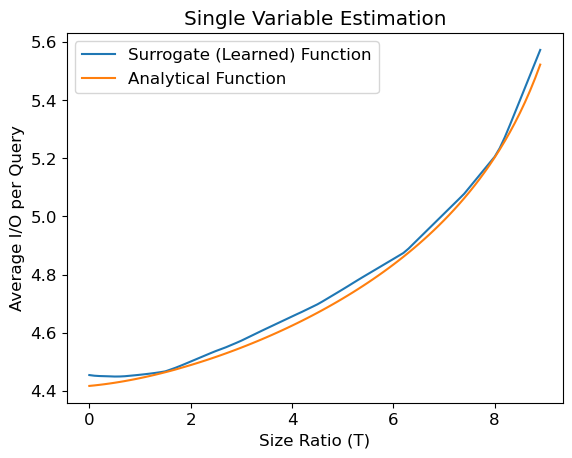

In [215]:
x = df['h']
y_learned = df['cost_lcm']
y_analytical = df['cost_acm']

fig, ax = plt.subplots()
ax.plot(x, y_learned, label='Surrogate (Learned) Function')
ax.plot(x, y_analytical, label='Analytical Function')
ax.set_xlabel('Size Ratio (T)')
ax.set_ylabel('Average I/O per Query')
ax.set_title('Single Variable Estimation')
ax.legend()
config_model['workloads'][idx]

### Random Configuration Estimation

In [216]:
def generate_random_samples(num_samples=100):
    gen = LevelGenerator(config_model)
    table = []
    for _ in tqdm(range(num_samples)):
        wl = (z0, z1, q, w) = gen._sample_workload(4)
        system = (B, s, E, H, N) = gen._sample_system()
        design = (h, T) = (gen._sample_bloom_filter_bits(max=(H - 0.1)), gen._sample_size_ratio())
        cost_lcm = eval_lcm(design, system, wl)
        cost_acm = eval_acm(design, system, wl)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": B,
            "s": s,
            "E": E,
            "H": H,
            "N": N,
            "h": h,
            "T": T,
            "cost_lcm": cost_lcm,
            "cost_acm": cost_acm,
        }
        table.append(row)
    table = pd.DataFrame(table)
    
    return table

In [217]:
num_samples = 10000
df = generate_random_samples(num_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [218]:
df['delta'] = abs(df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='cost_lcm', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,cost_lcm,cost_acm,delta,norm_delta
6819,0.01,0.00,0.22,0.77,4.00,0.00,8192,7.14,949626824,5.20,48,68.86,67.92,0.94,0.01
9394,0.03,0.02,0.39,0.55,4.00,0.00,8192,13.41,749533443,13.20,28,58.52,58.42,0.10,0.00
3902,0.04,0.00,0.24,0.72,4.00,0.00,8192,15.69,959638822,6.97,8,50.79,50.17,0.62,0.01
278,0.11,0.03,0.16,0.70,4.00,0.00,8192,7.83,788441179,7.48,42,49.10,48.58,0.52,0.01
4259,0.03,0.02,0.19,0.75,4.00,0.00,8192,13.28,985023102,7.65,20,44.28,43.78,0.50,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788,0.04,0.01,0.00,0.95,128.00,0.00,1024,16.12,350056840,4.38,10,0.16,0.17,0.01,0.05
9962,0.01,0.01,0.00,0.97,128.00,0.00,1024,9.96,949088141,2.86,3,0.15,0.15,0.01,0.05
4752,0.00,0.00,0.00,1.00,128.00,0.00,1024,17.92,703781507,8.92,6,0.14,0.13,0.02,0.15
1410,0.00,0.00,0.00,0.99,128.00,0.00,1024,16.53,104287422,11.64,5,0.13,0.14,0.01,0.06


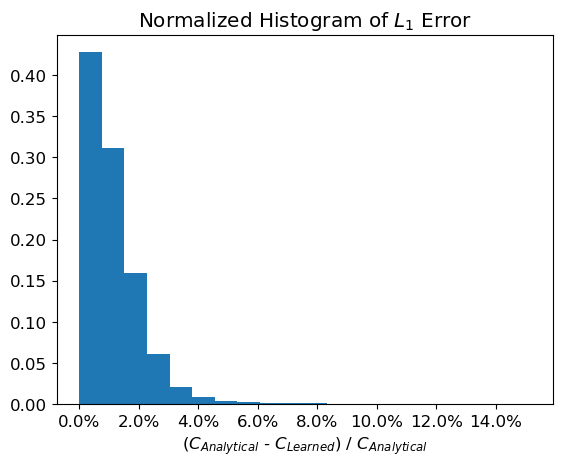

In [219]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
data = df['norm_delta'].values
ax.hist(data, bins=20, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))